In [1]:
from copy import deepcopy
import math
import sys

import matplotlib.pylab as plt
import numpy as np

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

sys.path.append('../crazyflie-audio/python/')

In [2]:
from generate_results import *

def plot_spectrum(spectrum, degree=0):
    plt.figure()
    if spectrum.shape[0] == 1:
        plt.plot(angles, np.log10(spectrum[0]))
        plt.ylabel('spectrum [-]')
    else:
        plt.pcolormesh(angles, frequencies, np.log10(spectrum))
        plt.ylabel('frequency [Hz]')
    plt.axvline(degree, color='red')
    plt.xlabel('angle [deg]')

# 1. Geometrical setup

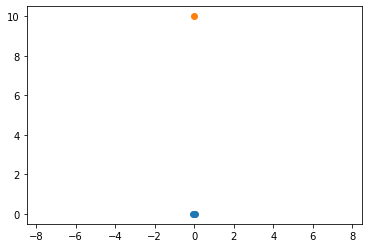

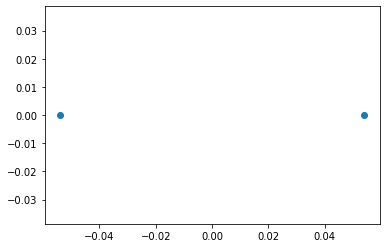

In [3]:
from mic_array import get_square_array, get_uniform_array

baseline = 0.108  # meters, square side of mic array
gt_distance = 10  # meters, distance of source
gt_angle_deg = 90 # angle of ground truth

#mics_drone = get_square_array(baseline=baseline, delta=0) # 4 x 2
mics_drone = get_uniform_array(2, baseline=baseline) # 4 x 2
mics_drone -= np.mean(mics_drone, axis=0) # center the drone

gt_angle_rad = gt_angle_deg * np.pi / 180.0
source = gt_distance * np.array([np.cos(gt_angle_rad), np.sin(gt_angle_rad)])

plt.figure()
plt.scatter(*mics_drone.T)
plt.scatter(*source)
plt.axis('equal')

plt.figure()
plt.scatter(*mics_drone.T)
plt.axis('equal')
pass

In [4]:
### parameters
n_buffer = 2048
angular_velocity_deg = 20 # deg/sec, velocity of drone
time_index = 1000 # idx where signal is non-zero for all positions, found heuristically
degrees = np.array([0, 20, 45], dtype=np.float) # orientations
frequency_desired = 600 # Hz

signal_noise = 1e-3  # noise added to signals
mics_noise = 1e-3  # noise added to mic positions (rigid)
degree_noise = 5 # noise added to each degree position, in degrees
time_quantization = 6 # number of decimal places to keep
time_noise = 1e-6 # noise added to recording times

# 2. Simulate signals at mics

chosen frequency: [593.75]
recording times in seconds: [0.   1.   2.25]


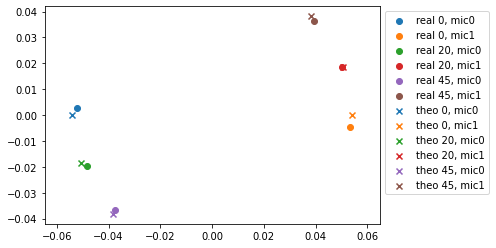

In [5]:
from audio_stack.beam_former import rotate_mics

np.random.seed(1)

frequencies = np.fft.rfftfreq(n_buffer, 1/FS)
indices = [np.argmin(np.abs(frequencies - frequency_desired))]
frequency_hz = frequencies[indices]
#signal_type = "random"; frequency_hz = None; 
print('chosen frequency:', frequency_hz)

if angular_velocity_deg != 0:
    times_list = (degrees-degrees[0])/angular_velocity_deg 
else:
    times_list = np.zeros(len(degrees))
print('recording times in seconds:', times_list)

assert DURATION > max(times_list)

# create noisy versions
mics_drone_noisy = deepcopy(mics_drone)
times_list_noisy = deepcopy(times_list)
degrees_noisy = deepcopy(degrees)
if mics_noise > 0:
    mics_drone_noisy += np.random.normal(scale=mics_noise, size=mics_drone.shape)
if time_noise > 0:
    times_list_noisy += np.random.normal(scale=time_noise, size=times_list.shape)
if time_quantization > 0:
    times_list_noisy = np.round(times_list_noisy, time_quantization)
if degree_noise > 0:
    degrees_noisy += np.random.normal(scale=degree_noise, size=degrees.shape)

# we think we move to "degrees" position but we actually move to degrees_noisy.
mics_list = [rotate_mics(mics_drone_noisy, orientation_deg=degree) for degree in degrees_noisy]

plt.figure()
counter = 0
for degree, mics in zip(degrees, mics_list):
    for j in range(mics.shape[0]):
        plt.scatter(*mics[j], label=f'real {degree:.0f}, mic{j}', color=f"C{counter}")
        counter += 1
        
counter = 0
mics_clean = [rotate_mics(mics_drone, orientation_deg=degree) for degree in degrees]
for degree, mics in zip(degrees, mics_clean):
    for j in range(mics.shape[0]):
        plt.scatter(*mics[j], label=f'theo {degree:.0f}, mic{j}', color=f"C{counter}", marker="x")
        counter += 1
plt.axis('equal')
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')
pass

# sanity check of signal creation

discrepancy of speed of sound with pyroomacoustics: 343.0 330
1.0 32000 32000
error: 1.0 1.0 0.0
shifted signals by 32000 (2, 161018)


(800.0, 2000.0)

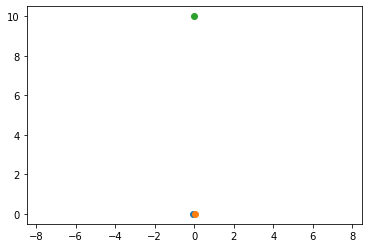

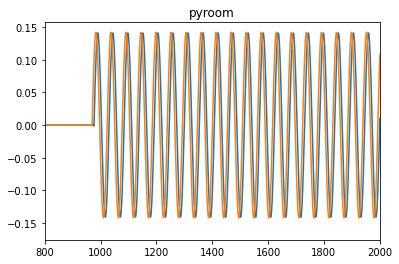

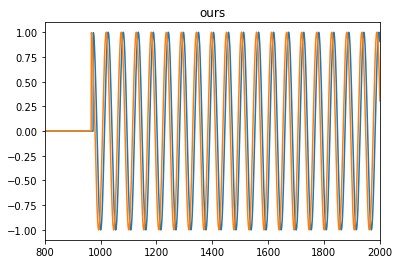

In [6]:
from signals import generate_signal, amplify_signal
source_signal = generate_signal(FS, 
                                signal_type="mono", 
                                duration_sec=DURATION, 
                                frequency_hz=frequency_hz, 
                                noise=signal_noise)
source_signal = amplify_signal(source_signal, target_dB=0)

fig, ax = plt.subplots()
for mic in mics_drone:
    ax.scatter(*mic)
ax.scatter(*source)
ax.axis('equal')
    
fig, ax = plt.subplots()
generate_signals_pyroom(source, source_signal, mics_list[-1].T, time=1.0, noise=0, ax=ax)
ax.set_title('pyroom')
ax.set_xlim(800, 2000)

fig, ax = plt.subplots()
generate_signals(source, gt_angle_rad, mics_list[-1], frequency_hz, time=1.0, noise=0, ax=ax)
ax.set_title('ours')
ax.set_xlim(800, 2000)

# generate signals

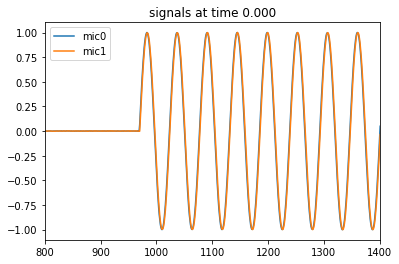

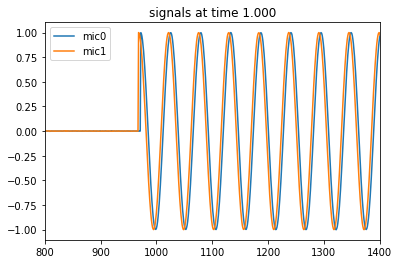

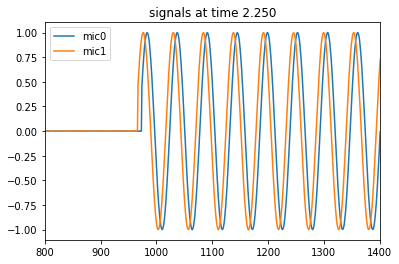

In [7]:
signals_list = []

for mics, time in zip(mics_list, times_list):
    fig, ax = plt.subplots()
    signals_received =  generate_signals(source, gt_angle_rad, mics, frequency_hz, time, noise=signal_noise, ax=ax) 
    #signals_received = generate_signals_pyroom(source, source_signal, mics.T, time, noise=signal_noise, ax=ax)
    ax.set_xlim(800, 1400)
    ax.legend([f"mic{i}" for i in range(mics.shape[0])])
    ax.set_title(f'signals at time {time:.3f}')
    
    signals_list.append(signals_received)
buffers = [signals_this[:, time_index:time_index + n_buffer] for signals_this in signals_list] 

# 3. Create "real" multi-mic array

Text(0.5, 0.98, 'multi-mic signals')

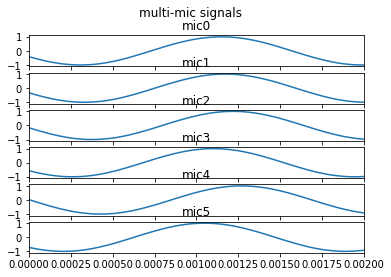

In [8]:
mics_array = np.concatenate([*mics_list])
signals_multimic = generate_signals(source, gt_angle_rad, mics_array, frequency_hz, time=0, noise=signal_noise)
#signals_multimic = generate_signals_pyroom(source, source_signal, mics_array.T, time=0, noise=signal_noise)
buffer_multimic = signals_multimic[:, time_index:time_index + n_buffer]

fig, axs = plt.subplots(buffer_multimic.shape[0], sharex=True)
for i in range(buffer_multimic.shape[0]): # n_mics
    label=f"mic{i}"
    axs[i].plot(np.arange(buffer_multimic.shape[1])/FS, buffer_multimic[i], label=label)
    axs[i].set_title(label)
    axs[i].set_xlim(0, 0.002)
plt.suptitle('multi-mic signals')

phase shift in degrees [359.78625]
phase shift in time [0.00168321]
phase shift in degrees [359.78625]
phase shift in time [0.00168321]
phase shift in degrees [90.4275]
phase shift in time [0.00042305]
phase shift in degrees [90.4275]
phase shift in time [0.00042305]
phase shift in degrees [22.0725]
phase shift in time [0.00010326]
phase shift in degrees [22.0725]
phase shift in time [0.00010326]


Text(0.5, 0.98, 'recorded signals without delay correction')

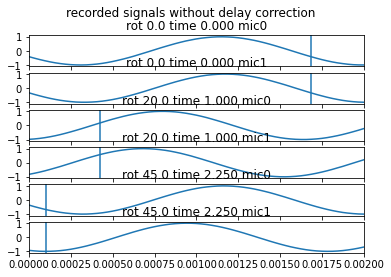

In [9]:
fig, axs = plt.subplots(buffer_multimic.shape[0], sharex=True)
counter = 0
for j, (degree, buffer, time) in enumerate(zip(degrees, buffers, times_list_noisy)):
    for i in range(buffer.shape[0]): # n_mics
        phase_shift = from_0_to_2pi(- 2 * np.pi * time * frequency_hz) * 180 / np.pi
        time_shift = phase_shift / (360 * frequency_hz)
        print("phase shift in degrees", phase_shift)
        print("phase shift in time", time_shift)
        label = f"rot {degree} time {time:.3f} mic{i}"
        axs[counter].axvline(time_shift)
        axs[counter].plot(np.arange(buffer.shape[1])/FS, buffer[i], label=label)
        axs[counter].set_title(label)
        axs[counter].set_xlim(0, 0.002)
        counter += 1
plt.suptitle('recorded signals without delay correction')

# 4. DOA estimation

# "real" spectrum

[[-0.054  0.   ]
 [ 0.054  0.   ]]


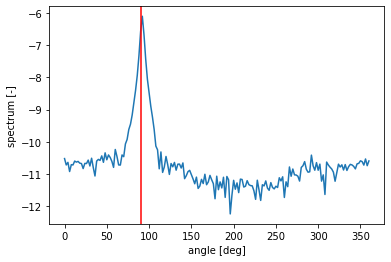

In [10]:
from audio_stack.beam_former import BeamFormer

mics_array_theoretical = np.concatenate([*mics_clean])
beam_former = BeamFormer(mic_positions=mics_array_theoretical)
print(mics_drone)
angles = beam_former.theta_scan * 180 / np.pi

signals_f_multimic = (np.fft.rfft(buffer_multimic).T)[indices, :]

if len(frequencies) > len(indices):
    frequencies = frequencies[indices]

R_multimic = beam_former.get_correlation(signals_f_multimic)
spectrum_multimic = beam_former.get_mvdr_spectrum(R_multimic, frequencies)
plot_spectrum(spectrum_multimic, degree=gt_angle_deg)

# combine spectra

In [11]:
beam_former = BeamFormer(mic_positions=mics_drone)

# calculate individual spectra for each pose
signals_f_list = [np.fft.rfft(buffer).T for buffer in buffers] # n_frequences x 4
signals_f_list = [sig_f[indices, :] for sig_f in signals_f_list]
    
Rs = [beam_former.get_correlation(sig_f) for sig_f in signals_f_list]
#spectra = [beam_former.get_das_spectrum(R, frequencies) for R in Rs]
spectra = [beam_former.get_mvdr_spectrum(R, frequencies) for R in Rs]

# combine the individual spectra, accounting for the orientation of the drone
#COMBINATION_METHOD = "sum"
NORMALIZATION_METHOD = "none"
#NORMALIZATION_METHOD = "sum_to_one"
#NORMALIZATION_METHOD = "zero_to_one"
COMBINATION_METHOD = "product"
beam_former.init_dynamic_estimate(combination_n=len(degrees), 
                                  combination_method=COMBINATION_METHOD, 
                                  normalization_method=NORMALIZATION_METHOD)
for spectrum, degree in zip(spectra, degrees):
    print(degree)
    beam_former.add_to_dynamic_estimates(spectrum, degree)

spectrum_combined = beam_former.get_dynamic_estimate()

0.0
20.0
45.0


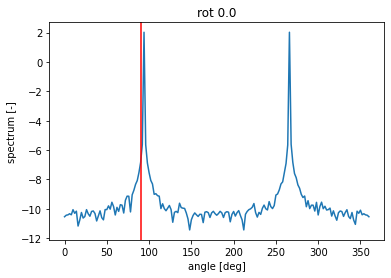

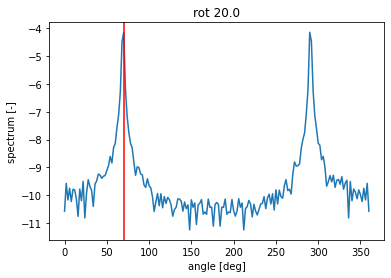

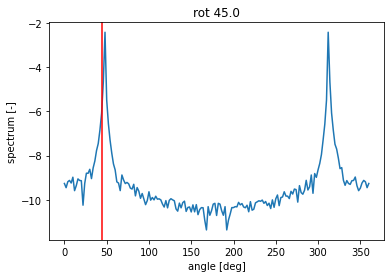

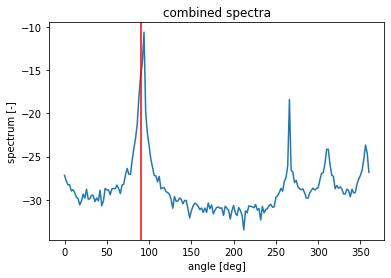

In [12]:
for spectrum, degree in zip(spectra, degrees):
    plot_spectrum(spectrum, from_0_to_360(gt_angle_deg - degree))
    plt.title(f'rot {degree}')

plot_spectrum(spectrum_combined, gt_angle_deg)
plt.title(f'combined spectra')
pass

In [13]:
# signals with delay correction

beam_former = BeamFormer(mic_positions=mics_drone)
beam_former.init_multi_estimate(frequencies)

signals_f_list_delayed = []
for i, (sig_f, time) in enumerate(zip(signals_f_list, times_list_noisy)):
    exp_factor = np.exp(1j * 2 * np.pi * frequencies * time)
    print('phase difference in degrees:', from_0_to_2pi(np.angle(exp_factor))*180/np.pi)
    signals_f_delayed = np.multiply(sig_f, exp_factor[:, np.newaxis])  # frequencies x n_mics
    signals_f_list_delayed.append(signals_f_delayed)
    
    beam_former.add_to_multi_estimate(sig_f, frequencies, time, degrees[i])
    
for sig_f, signals_f_delayed, time in zip(signals_f_list, signals_f_list_delayed, times_list):
    print(f'original phases (time={time:.3f}):', from_0_to_2pi(np.angle(sig_f)))
    print(f'corrected phases(time={time:.3f}):', from_0_to_2pi(np.angle(signals_f_delayed)))
    
print('multi-mic:', from_0_to_2pi(np.angle(signals_f_multimic)))

phase difference in degrees: [0.21375]
phase difference in degrees: [269.5725]
phase difference in degrees: [337.9275]
original phases (time=0.000): [[1.99289145 1.90823637]]
corrected phases(time=0.000): [[1.99662209 1.91196701]]
original phases (time=1.000): [[3.30710383 3.74267119]]
corrected phases(time=1.000): [[1.72884622 2.16441358]]
original phases (time=2.250): [[1.93946082 2.76314654]]
corrected phases(time=2.250): [[1.55422302 2.37790874]]
multi-mic: [[1.99285982 1.90821525 1.7361259  2.17164728 1.54594107 2.3696677 ]]


# combine raw signals

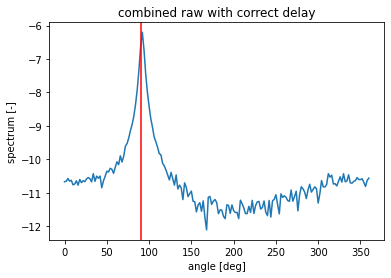

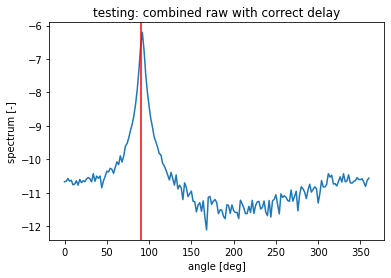

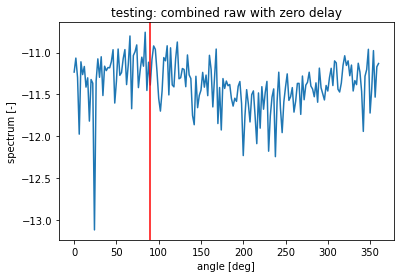

In [14]:
from algos_basics import get_mic_delays

beam_former_test = BeamFormer(mic_positions=mics_array_theoretical)

signals_f_tot_delay = np.empty((len(frequencies), 0))
signals_f_tot_zero = np.empty((len(frequencies), 0))

for i, (sig_f, signals_f_delayed) in enumerate(zip(signals_f_list, signals_f_list_delayed)):
    signals_f_tot_delay = np.c_[signals_f_tot_delay, signals_f_delayed]
    # for testing purposes, we also look at the spectra without compensating
    # for the delays.
    signals_f_tot_zero = np.c_[signals_f_tot_zero, sig_f]
    
Rtot_zero = beam_former_test.get_correlation(signals_f_tot_zero)
spectrum_raw_zero = beam_former_test.get_mvdr_spectrum(Rtot_zero, frequencies)

Rtot_delay = beam_former_test.get_correlation(signals_f_tot_delay)

spectrum_raw = beam_former_test.get_mvdr_spectrum(Rtot_delay, frequencies)

spectrum_raw_bf = beam_former.get_multi_estimate()

np.testing.assert_allclose(spectrum_raw_bf, spectrum_raw)

plot_spectrum(spectrum_raw_bf, degree=gt_angle_deg)
plt.title('combined raw with correct delay')

plot_spectrum(spectrum_raw, degree=gt_angle_deg)
plt.title('testing: combined raw with correct delay')

plot_spectrum(spectrum_raw_zero, degree=gt_angle_deg)
plt.title('testing: combined raw with zero delay')
pass

# compare results

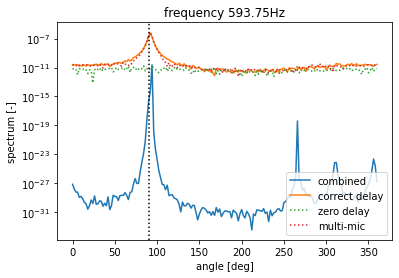

In [15]:
for i, freq in enumerate(frequencies):
    plt.figure()
    plt.semilogy(angles, spectrum_combined[i], label='combined')
    plt.semilogy(angles, spectrum_raw[i], label='correct delay')
    plt.semilogy(angles, spectrum_raw_zero[i], label='zero delay', ls=':')
    plt.semilogy(angles, spectrum_multimic[i], label='multi-mic', ls=':')
    plt.axvline(gt_angle_deg, color='black', ls=':')
    plt.legend(loc='lower right')
    plt.title(f'frequency {freq:.2f}Hz')
    plt.xlabel('angle [deg]')
    plt.ylabel('spectrum [-]')

# Full pipeline

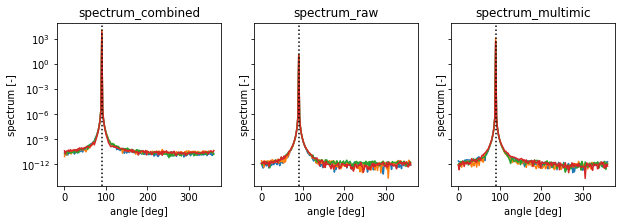

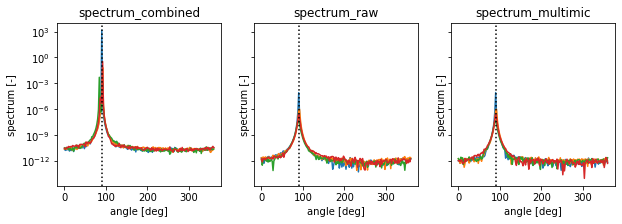

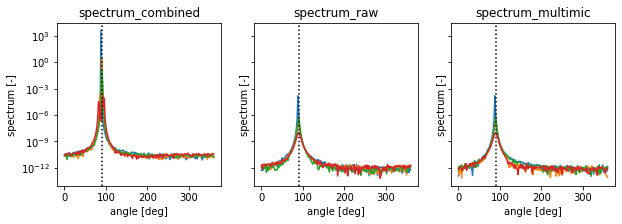

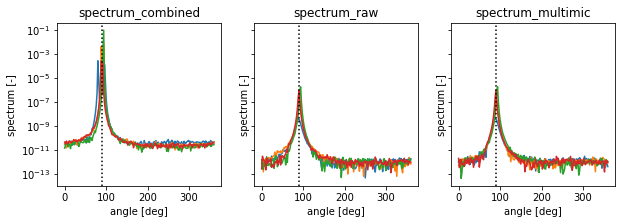

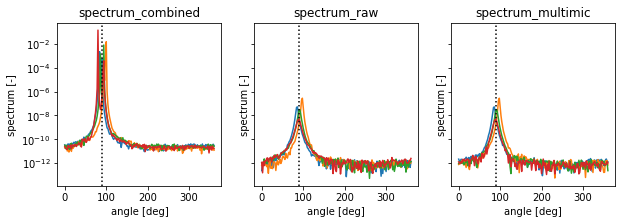

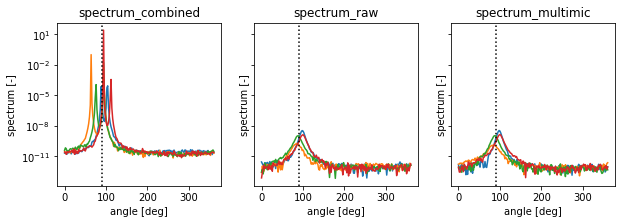

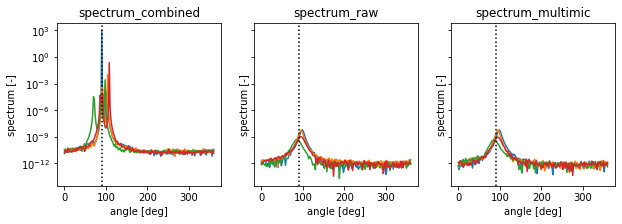

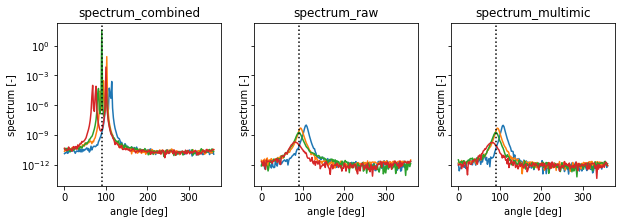

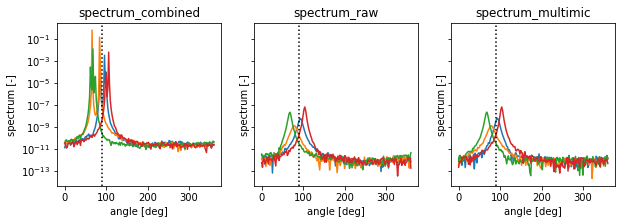

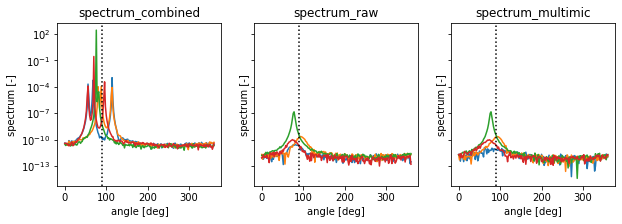

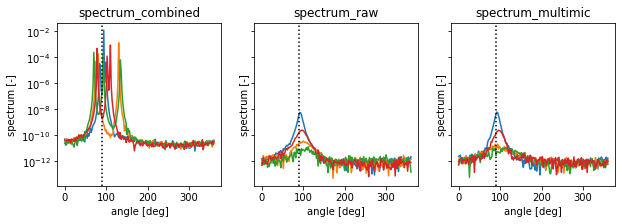

In [16]:
import pandas as pd

#fname = 'first_test.pkl' # linear array
fname = 'square_test.pkl' # square array
df = pd.read_pickle(fname)
freq_i = 0

label_list = ['spectrum_combined', 'spectrum_raw', 'spectrum_multimic']

n_degree_noise = len(df.degree_noise.unique())
n_it = len(df.it.unique())
boxplot_mat = np.empty((len(label_list), n_it, n_degree_noise)) # each slice will be one boxplot

for d, (degree_noise, df_degree_noise) in enumerate(df.groupby('degree_noise')):
    fig, axs = plt.subplots(1, len(label_list), sharey=True, sharex=True)
    fig.set_size_inches(10, 3)
    for counter, (__, row) in enumerate(df_degree_noise.iterrows()):
        for l, label in enumerate(label_list):
            if counter <= 3:
                axs[l].semilogy(angles, row[label][freq_i])
                
            unwrap_angles = np.array([angles[np.argmax(row[label][freq_i])], gt_angle_deg]) / 180 * np.pi
            unwrap_angles = np.unwrap(unwrap_angles)
            error = abs(unwrap_angles[1] - unwrap_angles[0])*180/np.pi
            
            boxplot_mat[l, counter, d] = error
        
    for label, ax in zip(label_list, axs):
        ax.axvline(gt_angle_deg, color='black', ls=':')
        ax.set_title(f'degree noise {degree_noise}')
        ax.set_xlabel('angle [deg]')
        ax.set_ylabel('spectrum [-]')
        ax.set_title(label)

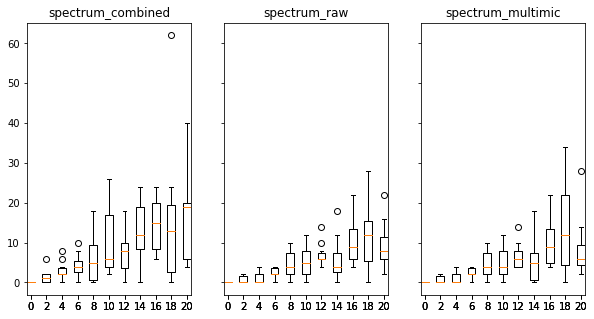

In [17]:
fig_box, ax_box = plt.subplots(1, len(label_list), sharex=True, sharey=True)
fig_box.set_size_inches(10, 5)
for l, label in enumerate(label_list):
    ax_box[l].boxplot(boxplot_mat[l], positions=df.degree_noise.unique(), widths=1.0)
    ax_box[l].set_title(label)